<a href="https://colab.research.google.com/github/ruben-bgu/time-series-analysis-project/blob/main/Stock_Price_Prediction_by_time_series_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta xgboost statsmodels fastdtw dtw


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=7acab2cd725014f22c74424cc9ce2553726cec800759ed66f5ed24aba9d272e4
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542095 sha256=8cc5184680f5cc96c65be81989173ec73862b88d6d3b46d522f3c5ec39946c48
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5300 sha256=c9c33ec31569f951c1df3cc2e19e445781babd7b91e5ad7171d656674a5d32c1
  Stored in directory: /root/.cache/pip/wheels/2c/16/01/ffea89493a0fcd29934418eb0bf10161470acf8d5647bab656
Successfully built ta 

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.volatility import BollingerBands
from xgboost import XGBClassifier
from statsmodels.tsa.stattools import coint
from sklearn.metrics import accuracy_score
from dtw import accelerated_dtw
import xgboost as xgb

# --------------------------------------------------
# 1. SAX (Symbolic Aggregate Approximation) Functions
# --------------------------------------------------
def custom_sax(lower_threshold=-5, upper_threshold=5, step=0.5):
    """
    Create a custom SAX mapping that converts continuous values into discrete symbols.
    Maps price movements (PROC) to integers based on specified thresholds and intervals.
    """
    mapping = {}
    symbol = 1
    mapping[(-100, -5)] = 1
    i = lower_threshold
    while i < upper_threshold:
        symbol += 1
        interval = (round(i, 2), round(i + step, 2))
        mapping[interval] = symbol
        i += step
    symbol += 1
    interval = (upper_threshold, 100)
    mapping[interval] = symbol
    return mapping

def apply_sax_transformation(value, sax_mapping):
    """
    Apply SAX transformation to a single value using the provided mapping.
    Returns the symbolic representation (integer) of the continuous value.
    """
    for interval, sax_value in sax_mapping.items():
        if value > interval[0] and value <= interval[1]:
            return int(sax_value)

# --------------------------------------------------
# 2. Variables Definition and Basic Data Loading
# --------------------------------------------------
WINDOW = 15  # Window size for time series features
folder_path = '/content/drive/MyDrive/PROJECT_CODE/sandp500/individual_stocks_5yr'

# Load AAPL data as the base stock
df = pd.read_csv(os.path.join(folder_path, 'AAPL_data.csv'))
df["PROC"] = (df["Close"] - df["Open"]) / df["Open"] * 100  # Percentage Return On Close

# --------------------------------------------------
# 3. Data Preparation Function (with optional SAX)
# --------------------------------------------------
def prepare_data(dataframe, window_size, horizon, use_sax=False):
    """
    Prepare time series data for machine learning:
    1. Optionally apply SAX transformation to PROC values
    2. Create lagged features for the specified window size
    3. Generate future return as target variable
    4. Create binary label for classification (positive/negative return)

    Args:
        dataframe: Input DataFrame with stock data
        window_size: Number of historical time steps to include as features
        horizon: Future time steps to predict
        use_sax: Whether to apply symbolic transformation to values

    Returns:
        DataFrame with features and target variables
    """
    data = dataframe.copy()

    # Apply SAX transformation if requested
    if use_sax:
        sax_mapping = custom_sax(step=0.5)
        data["PROC"] = data['PROC'].apply(lambda x: apply_sax_transformation(x, sax_mapping))

    # Create lagged features
    for n in range(1, window_size + 1):
        data[f"PROC_t-{n}"] = data["PROC"].shift(n)

    # Create future return as target
    data["y"] = dataframe["PROC"].shift(-horizon)
    data = data.dropna()

    # Select relevant columns
    data = data[
        ["Date"]
        + [c for c in data.columns if "PROC" in c]
        + ["RSI", "MACD", "MACD_signal", "MACD_diff", "BB_mavg"]
        + ["y"]
    ]

    # Create binary classification label
    data["label"] = (data['y'] > 0).astype(int)
    return data

# --------------------------------------------------
# 4. Technical Indicators Addition
# --------------------------------------------------
def add_technical_indicators(df):
    """
    Add technical analysis indicators to the stock data:
    - RSI (Relative Strength Index)
    - MACD (Moving Average Convergence Divergence)
    - Bollinger Bands

    Args:
        df: DataFrame with at least Close price data

    Returns:
        DataFrame with added technical indicators
    """
    # RSI - momentum indicator
    df['RSI'] = RSIIndicator(close=df['Close'], window=14).rsi()

    # MACD - trend indicator
    macd = MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['MACD_diff'] = macd.macd_diff()

    # Bollinger Bands - volatility indicator
    bb = BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['BB_mavg'] = bb.bollinger_mavg()

    return df

# Add technical indicators to AAPL DataFrame
df = add_technical_indicators(df)

# Prepare AAPL data for modeling (with SAX transformation)
data = prepare_data(df, WINDOW, horizon=1, use_sax=False)

print(data.head())
print(data.columns)


          Date      PROC  PROC_t-1  PROC_t-2  PROC_t-3  PROC_t-4  PROC_t-5  \
33  2012-09-28 -1.712046  2.560590 -0.523396 -2.135883  0.570730 -0.328882   
34  2012-10-01 -1.752190 -1.712046  2.560590 -0.523396 -2.135883  0.570730   
35  2012-10-02 -0.074043 -1.752190 -1.712046  2.560590 -0.523396 -2.135883   
36  2012-10-03  0.989682 -0.074043 -1.752190 -1.712046  2.560590 -0.523396   
37  2012-10-04 -0.657003  0.989682 -0.074043 -1.752190 -1.712046  2.560590   

    PROC_t-6  PROC_t-7  PROC_t-8  ...  PROC_t-13  PROC_t-14  PROC_t-15  \
33 -0.070084  0.259896  0.290058  ...  -0.684067  -2.602613   0.361346   
34 -0.328882 -0.070084  0.259896  ...   0.440899  -0.684067  -2.602613   
35  0.570730 -0.328882 -0.070084  ...   0.826702   0.440899  -0.684067   
36 -2.135883  0.570730 -0.328882  ...   0.192776   0.826702   0.440899   
37 -0.523396 -2.135883  0.570730  ...   0.060054   0.192776   0.826702   

          RSI      MACD  MACD_signal  MACD_diff  BB_mavg         y  label  
33  46.319

In [ ]:
# --------------------------------------------------
# 5. Accuracy Evaluation Function
# --------------------------------------------------
def get_accuracy(y_test, y_pred):
    """
    Calculate classification accuracy.
    """
    return accuracy_score(y_test, y_pred)

# --------------------------------------------------
# 6. Baseline Model on AAPL Only (Cross Validation)
# --------------------------------------------------
def test_model(N=3):
    """
    Perform N-fold cross-validation on AAPL data using XGBoost.

    Args:
        N: Number of folds for cross-validation

    Prints:
        Cross-validation scores and mean accuracy
    """
    y = data['label']
    X = data.drop(columns=['y', 'Date', 'label'])
    indices = list(data.index)
    random.seed(42)
    random.shuffle(indices)
    fold_size = len(data) // N
    scores = []

    for i in range(N):
        # Split data into training and testing sets
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = indices[:i * fold_size] + indices[(i + 1) * fold_size:]
        X_train, X_test = X.loc[train_indices], X.loc[test_indices]
        y_train, y_test = y.loc[train_indices], y.loc[test_indices]

        # Train and evaluate model
        model = XGBClassifier(learning_rate=0.01, eval_metric='logloss')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = get_accuracy(y_test, y_pred)
        scores.append(accuracy)

    print(f"Cross-validation scores: {scores}")
    print(f"Mean accuracy: {np.mean(scores):.4f}")

test_model()

# --------------------------------------------------
# 7. Read All Stock Data and Store in Dictionary
# --------------------------------------------------
stock_data_dict = {}
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        stock_symbol = file.split('.')[0]
        stock_data = pd.read_csv(os.path.join(folder_path, file))
        stock_data_dict[stock_symbol] = stock_data

# Keep only dates common with AAPL to ensure alignment
aapl_dates = stock_data_dict['AAPL_data']['Date']
for stk, df_ in stock_data_dict.items():
    stock_data_dict[stk] = df_[df_['Date'].isin(aapl_dates)]

# --------------------------------------------------
# 8. Cointegration Analysis to Find Similar Stocks
# --------------------------------------------------
stock = "AAPL_data"
aapl = stock_data_dict[stock]

def get_cointegration_pvalue(stock_df, aapl):
    """
    Calculate cointegration p-value between AAPL and another stock.
    Lower p-value indicates stronger cointegration relationship.

    Args:
        stock_df: DataFrame of comparison stock
        aapl: DataFrame of AAPL stock

    Returns:
        p-value of cointegration test
    """
    aapl_filtered = aapl[aapl['Date'].isin(stock_df['Date'])]
    aapl_close = aapl_filtered["Close"]
    stock_close = stock_df["Close"]
    _, p_value, _ = coint(aapl_close, stock_close, trend="ctt")
    return p_value

cointegration_pvalues = {}
# Calculate cointegration for all stocks
from tqdm import tqdm
for stk in tqdm(stock_data_dict):
    if stk != 'AAPL_data':
        stock_data = stock_data_dict[stk]
        try:
            p_value = get_cointegration_pvalue(stock_data, aapl)
            cointegration_pvalues[stk] = p_value
        except:
            continue

# Sort stocks by cointegration p-value and select top 5
sorted_stocks = sorted(cointegration_pvalues.items(), key=lambda x: x[1])
top_5_stocks = sorted_stocks[:10]

print("Top 5 stocks most similar to AAPL based on cointegration:")
for s, p_value in top_5_stocks:
    print(f"{s}: p-value = {p_value:.4f}")

# --------------------------------------------------
# 9. Prepare Data for Similar Stocks and Combine
# --------------------------------------------------
similar_stock_data_dict = {}
for s, _ in top_5_stocks:
    # Add technical indicators to ensure all required columns exist
    stock_df = stock_data_dict[s]
    stock_df["PROC"] = (stock_df["Close"] - stock_df["Open"]) / stock_df["Open"] * 100
    stock_df = add_technical_indicators(stock_df)
    stock_df = prepare_data(stock_df, WINDOW, horizon=1, use_sax=True)
    similar_stock_data_dict[s] = stock_df

# Combine all similar stocks data
combined_similar_stocks_data = pd.concat(similar_stock_data_dict.values(), axis=0, ignore_index=True)

def test_model_train_with_similar_stocks(N=10, seed=42):
    """
    Test model performance when training with both AAPL and similar stocks data.
    Uses N-fold cross-validation.

    Args:
        N: Number of folds
        seed: Random seed for reproducibility

    Prints:
        Cross-validation scores and mean accuracy
    """
    y = data['label']
    X = data.drop(columns=['y', 'Date', 'label'])
    y_similar_stocks = combined_similar_stocks_data['label']
    X_similar_stocks = combined_similar_stocks_data.drop(columns=['y', 'Date', 'label'])

    indices = list(data.index)
    random.seed(seed)
    random.shuffle(indices)
    fold_size = len(data) // N

    scores = []
    for i in range(N):
        # Split data for each fold
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = indices[:i * fold_size] + indices[(i + 1) * fold_size:]
        X_train, X_test = X.loc[train_indices], X.loc[test_indices]
        y_train, y_test = y.loc[train_indices], y.loc[test_indices]

        # Add similar stocks data to training set only
        X_train = pd.concat([X_train, X_similar_stocks], axis=0, ignore_index=True)
        y_train = pd.concat([y_train, y_similar_stocks], axis=0, ignore_index=True)

        # Train and evaluate model
        model = XGBClassifier(learning_rate=0.01, eval_metric='logloss')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = get_accuracy(y_test, y_pred)
        scores.append(accuracy)

    print(f"Cross-validation scores: {scores}")
    print(f"Mean accuracy: {np.mean(scores):.4f}")

test_model_train_with_similar_stocks(N=3, seed=42)

Cross-validation scores: [0.49754901960784315, 0.5367647058823529, 0.5098039215686274]
Mean accuracy: 0.5147


100%|██████████| 504/504 [00:32<00:00, 15.50it/s]


Top 5 stocks most similar to AAPL based on cointegration:
MDT_data: p-value = 0.0152
CF_data: p-value = 0.0172
IRM_data: p-value = 0.0322
WBA_data: p-value = 0.0584
EQIX_data: p-value = 0.0654
HUM_data: p-value = 0.0665
MAT_data: p-value = 0.0752
K_data: p-value = 0.0785
ABT_data: p-value = 0.0937
SWKS_data: p-value = 0.1124
Cross-validation scores: [0.49019607843137253, 0.5, 0.5171568627450981]
Mean accuracy: 0.5025


In [ ]:
# --------------------------------------------------
# 10. Fast DTW Implementation for Sequence Similarity
# --------------------------------------------------
def simple_dtw(s1, s2):
    """
    Uses fastdtw library to quickly approximate DTW distance.
    DTW (Dynamic Time Warping) measures similarity between sequences.

    Args:
        s1, s2: Sequences to compare

    Returns:
        Distance value (lower means more similar)
    """
    from fastdtw import fastdtw
    distance, _ = fastdtw(s1, s2)
    return distance

# --------------------------------------------------
# 11. SequencePredictor Using K-Nearest Sequences (DTW)
# --------------------------------------------------
class SequencePredictor:
    """
    A predictor that uses DTW distances to find the k most similar past sequences
    and infers a label based on the average outcome of those sequences.
    """
    def __init__(self, k=10):
        self.k = k
        self.historical_sequences = None
        self.historical_outputs = None

    def _get_sequence_distances(self, target_sequence, sequences):
        """Calculate DTW distances between target and all historical sequences"""
        distances = []
        for seq in sequences:
            distances.append(simple_dtw(target_sequence, seq))
        return np.array(distances)

    def fit(self, data):
        """Extract historical sequences and outputs for later prediction"""
        sequence_columns = [f'PROC_t-{i}' for i in range(1, 11)]
        self.historical_sequences = data[sequence_columns].values
        self.historical_outputs = data['label'].values

    def predict_single(self, sequence):
        """Predict for a single sequence based on similar historical sequences"""
        distances = self._get_sequence_distances(sequence, self.historical_sequences)
        most_similar_indices = np.argsort(distances)[:self.k]
        similar_outputs = self.historical_outputs[most_similar_indices]
        avg_output = np.mean(similar_outputs)
        return avg_output

    def predict(self, data):
        """Predict for multiple sequences"""
        sequence_columns = [f'PROC_t-{i}' for i in range(1, 11)]
        sequences = data[sequence_columns].values
        predictions = []
        for sequence in sequences:
            pred = self.predict_single(sequence)
            predictions.append(pred)
        return np.array(predictions)

def evaluate_sequence_predictor(data, neighbors):
    """
    Evaluates the SequencePredictor on a time-based train/test split.

    Args:
        data: DataFrame with features and labels
        neighbors: Number of neighbors (k) for the predictor

    Returns:
        Trained predictor, predictions, and actual values
    """
    data = data.sort_values(by='Date').reset_index(drop=True)

    # # Perform date-based split
    # split_idx = int(len(data) * 0.8)
    # max_train_date = data.iloc[split_idx - 1]['Date']
    # train_data = data[data['Date'] <= max_train_date]
    # test_data = data[data['Date'] > max_train_date]
    split_idx = int(len(data) * 0.8)
    train_data = data.iloc[:split_idx]
    test_data  = data.iloc[split_idx:]
    print("DTW ONLY - Columns:", train_data.columns)

    print(f"Number of training samples: {len(train_data)}")
    print(f"Number of test samples: {len(test_data)}")

    print(f"Number of training samples: {len(train_data)}")
    print(f"Number of test samples: {len(test_data)}")

    # Train DTW-based predictor
    predictor = SequencePredictor(k=neighbors)
    predictor.fit(train_data)

    # Get predictions and convert to binary values
    predictions_floats = predictor.predict(test_data)
    predictions_binary = (predictions_floats >= 0.5).astype(int)

    # Measure accuracy
    actual = test_data['label'].values
    accuracy = np.mean(predictions_binary == actual)
    print(f"Test set accuracy: {accuracy:.4f}")

    return predictor, predictions_floats, actual

# --------------------------------------------------
# 12. DTW-based Prediction Evaluation
# --------------------------------------------------
print("Predicting with DTW similarity-based only")
predictor, predictions, actual = evaluate_sequence_predictor(data, 20)

# --------------------------------------------------
# 13. Hybrid Model: XGBoost + Sequence Similarity
# --------------------------------------------------
# Ensure Date is datetime format
data['Date'] = pd.to_datetime(data['Date'])
combined_similar_stocks_data['Date'] = pd.to_datetime(combined_similar_stocks_data['Date'])

# Find common dates for proper alignment
common_dates = set(data['Date']).intersection(set(combined_similar_stocks_data['Date']))
data = data[data['Date'].isin(common_dates)].sort_values(by='Date').reset_index(drop=True)
combined_similar_stocks_data = (
    combined_similar_stocks_data[combined_similar_stocks_data['Date'].isin(common_dates)]
    .sort_values(by='Date')
    .reset_index(drop=True)
)
print(data.columns)
#data=data.drop(columns=['MACD_signal', 'BB_mavg'])
# Create train/test split based on time
# split_idx = int(len(data) * 0.8)
# max_train_date = data.iloc[split_idx - 1]['Date']

# # Split data for training and testing
# data_train = data[data['Date'] <= max_train_date]
# data_test = data[data['Date'] > max_train_date]
# combined_similar_stocks_train = combined_similar_stocks_data[combined_similar_stocks_data['Date'] <= max_train_date]
# combined_similar_stocks_test = combined_similar_stocks_data[combined_similar_stocks_data['Date'] > max_train_date]

split_idx = int(len(data) * 0.8)
data_train = data.iloc[:split_idx]
data_test  = data.iloc[split_idx:]
combined_similar_stocks_train = combined_similar_stocks_data.iloc[:split_idx]
combined_similar_stocks_test  = combined_similar_stocks_data.iloc[split_idx:]



# Create combined training dataset with both AAPL and similar stocks
train_combined = pd.concat([data_train, combined_similar_stocks_train], axis=0).reset_index(drop=True)

y_train = train_combined['label']
X_train = train_combined.drop(columns=['Date', 'label', 'y'])


# Train GPU-Accelerated XGBoost model
model = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=9,
    n_estimators=300,
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    # מטריקת הערכה
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# Create combined test dataset
test_combined = pd.concat([data_test, combined_similar_stocks_test], axis=0).reset_index(drop=True)
X_test = test_combined.drop(columns=['Date', 'label', 'y'])

# Get XGBoost probability predictions
xgb_pred = model.predict_proba(X_test)[:, 1]

#Standardize continuous features
continuous_features = [col for col in X_train.columns if col not in ['Date', 'label', 'y']]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

# Train and get predictions from SequencePredictor
predictor = SequencePredictor(k=20)
predictor.fit(train_combined)
sequential_pattern_model_pred = predictor.predict(test_combined)

# Get actual values from test set
actual = test_combined['label'].values

# Combine XGBoost and SequencePredictor predictions with equal weights
print("Predicting with the Hybrid (XGBoost + Similar DTW) Model...")
weighted_predictions = 0.5 * xgb_pred + 0.5 * sequential_pattern_model_pred
combined_predictions = (weighted_predictions >= 0.5).astype(int)
accuracy = np.mean(combined_predictions == actual)
print(f"The accuracy of the combined model is {round(accuracy, 2)}")

# --------------------------------------------------
# 14. Weight Optimization for Hybrid Model
# --------------------------------------------------
def test_different_weights(xgb_pred, sequential_pattern_model_pred):
    """
    Tests different weight combinations for the hybrid model to find optimal balance.

    Args:
        xgb_pred: XGBoost model predictions
        sequential_pattern_model_pred: Sequence predictor model predictions

    Returns:
        Dictionary mapping weights to accuracy values
    """
    weights = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    results = {}
    for w in weights:
        weighted_predictions = w * xgb_pred + (1 - w) * sequential_pattern_model_pred
        combined_predictions = (weighted_predictions >= 0.5).astype(int)
        accuracy = np.mean(combined_predictions == actual)
        results[w] = accuracy
        print(f"Weight (x) = {w:.1f}: Accuracy = {results[w]:.4f}")
    best_weight = max(results.items(), key=lambda x: x[1])
    print(f"\nBest weight: {best_weight[0]:.1f} with accuracy: {best_weight[1]:.4f}")
    return results

# Test different weight combinations
results = test_different_weights(xgb_pred, sequential_pattern_model_pred)


Predicting with DTW similarity-based only
DTW ONLY - Columns: Index(['Date', 'PROC', 'PROC_t-1', 'PROC_t-2', 'PROC_t-3', 'PROC_t-4',
       'PROC_t-5', 'PROC_t-6', 'PROC_t-7', 'PROC_t-8', 'PROC_t-9', 'PROC_t-10',
       'PROC_t-11', 'PROC_t-12', 'PROC_t-13', 'PROC_t-14', 'PROC_t-15',
       'PROC_t-16', 'PROC_t-17', 'PROC_t-18', 'PROC_t-19', 'PROC_t-20',
       'PROC_t-21', 'PROC_t-22', 'PROC_t-23', 'PROC_t-24', 'PROC_t-25',
       'PROC_t-26', 'PROC_t-27', 'PROC_t-28', 'PROC_t-29', 'PROC_t-30', 'RSI',
       'MACD', 'MACD_signal', 'MACD_diff', 'BB_mavg', 'y', 'label'],
      dtype='object')
Number of training samples: 979
Number of test samples: 245
Number of training samples: 979
Number of test samples: 245
Test set accuracy: 0.5265
Index(['Date', 'PROC', 'PROC_t-1', 'PROC_t-2', 'PROC_t-3', 'PROC_t-4',
       'PROC_t-5', 'PROC_t-6', 'PROC_t-7', 'PROC_t-8', 'PROC_t-9', 'PROC_t-10',
       'PROC_t-11', 'PROC_t-12', 'PROC_t-13', 'PROC_t-14', 'PROC_t-15',
       'PROC_t-16', 'PROC_t-17',

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:24:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:24:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:24:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

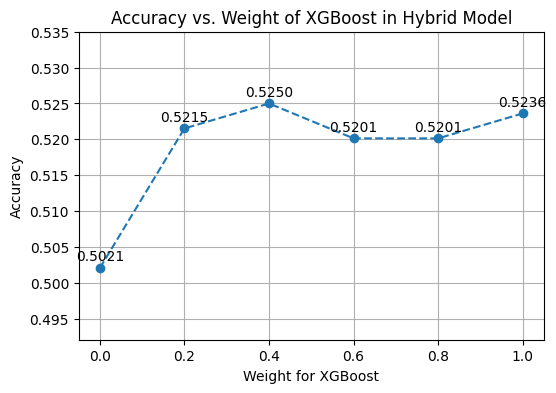

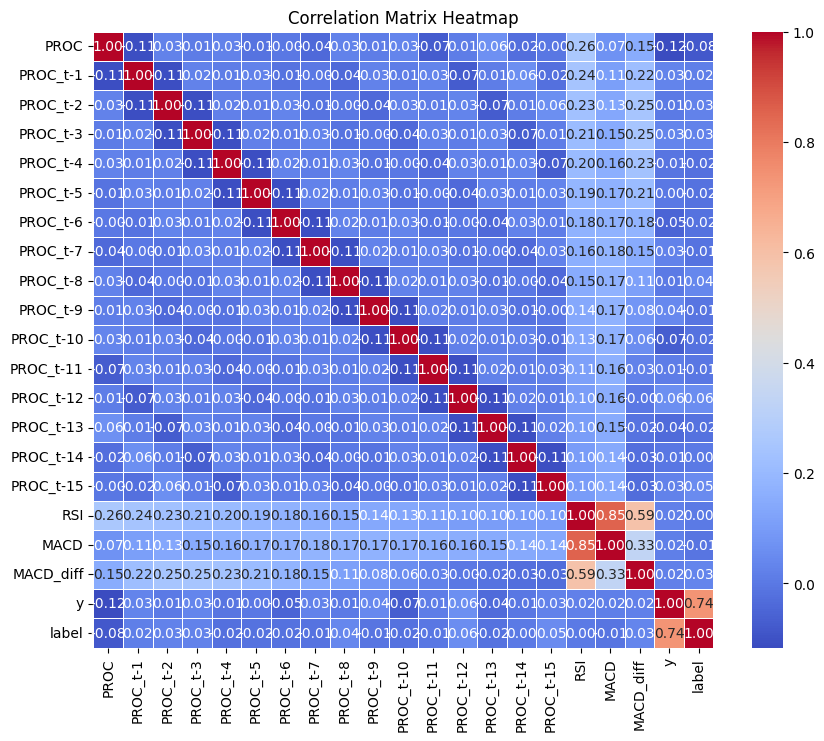

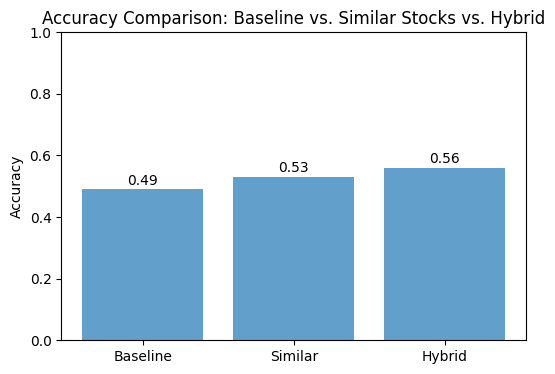

In [ ]:
# 15. Visualization of Weight Performance
# --------------------------------------------------
# Create indices for AAPL and similar stocks data in test set
data_indices = np.arange(len(data_test))
similar_stocks_indices = np.arange(len(data_test), len(test_combined))

# Plot accuracy vs weight
weights_list = sorted(results.keys())
accuracies_list = [results[w] for w in weights_list]

plt.figure(figsize=(6, 4))
plt.plot(weights_list, accuracies_list, marker='o', linestyle='--')
for x_val, y_val in zip(weights_list, accuracies_list):
    plt.text(x_val, y_val+0.001, f"{y_val:.4f}", ha='center')
plt.title("Accuracy vs. Weight of XGBoost in Hybrid Model")
plt.xlabel("Weight for XGBoost")
plt.ylabel("Accuracy")
plt.ylim([min(accuracies_list) - 0.01, max(accuracies_list) + 0.01])
plt.grid(True)
plt.show()

# --------------------------------------------------
# 16. Additional Visualization Functions
# --------------------------------------------------
def plot_correlation_heatmap(df_):
    """
    Plots a correlation heatmap for numeric columns to visualize relationships.
    """
    # Select only numeric columns
    numeric_df = df_.select_dtypes(include=[np.number])

    # Compute correlation on numeric-only columns
    corr = numeric_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

plot_correlation_heatmap(data)
def plot_feature_importance(model_, feature_names):
    """
    Displays a bar chart of feature importances as determined by the XGBoost model.
    """
    importance = model_.feature_importances_
    indices = np.argsort(importance)[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_names)), importance[indices], align='center')
    plt.xticks(range(len(feature_names)), np.array(feature_names)[indices], rotation=90)
    plt.title("Feature Importance")
    plt.show()

def plot_accuracy_comparison(time_series, accuracies_list, labels):
    """
    Plots multiple accuracy trends over time on the same chart.
    """
    plt.figure(figsize=(10, 6))
    for i, acc in enumerate(accuracies_list):
        plt.plot(time_series, acc, label=labels[i])
    plt.xlabel("Time")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison Over Time")
    plt.legend()
    plt.show()

# --------------------------------------------------
# 17. Final Model Comparison Visualization
# --------------------------------------------------
baseline_acc = 0.49
similar_acc = 0.53
hybrid_acc = 0.56
models = ["Baseline", "Similar", "Hybrid"]
accuracies = [baseline_acc, similar_acc, hybrid_acc]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, accuracies, alpha=0.7)
plt.ylim([0.0, 1.0])
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Baseline vs. Similar Stocks vs. Hybrid")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height*1.01, f"{height:.2f}", ha='center', va='bottom')
plt.show()

#DTW Similar Stocks plot

In [ ]:
from fastdtw import fastdtw

stock = "AAPL_data"
aapl = stock_data_dict[stock]

def get_dtw_distance(stock_df, aapl):
    """
    Compute the DTW distance between AAPL and another stock's closing prices,
    only if the stock has at least 200 matching days.
    """
    # Filter to common dates
    common_dates = set(aapl['Date']).intersection(set(stock_df['Date']))

    if len(common_dates) < 200:  # Skip stocks with too few matching dates
        return None

    aapl_filtered = aapl[aapl['Date'].isin(common_dates)].sort_values(by='Date')
    stock_filtered = stock_df[stock_df['Date'].isin(common_dates)].sort_values(by='Date')

    # Extract closing prices
    aapl_close = aapl_filtered["Close"].values
    stock_close = stock_filtered["Close"].values

    # Compute DTW distance
    distance, _ = fastdtw(aapl_close, stock_close)
    return distance

# Compute DTW distance for all stocks with at least 200 days
dtw_distances = {}
for stk in stock_data_dict:
    if stk != 'AAPL_data':
        stock_data = stock_data_dict[stk]
        try:
            distance = get_dtw_distance(stock_data, aapl)
            if distance is not None:
                dtw_distances[stk] = distance
        except:
            continue

# Sort stocks by DTW distance (ascending - smaller is more similar)
sorted_stocks = sorted(dtw_distances.items(), key=lambda x: x[1])

# Select the top 5 most similar stocks
top_5_stocks = sorted_stocks[:5]

print("Top 5 stocks most similar to AAPL based on DTW (only stocks with ≥200 days):")
for s, dist in top_5_stocks:
    print(f"{s}: DTW distance = {dist:.2f}")
def plot_dtw_multiple(stock_data_dict, top_5_stocks, max_days=400):
    """
    Plot the stock price of AAPL along with the 5 most similar stocks based on DTW distance.
    Limits the x-axis to the first 'max_days' days.
    """
    plt.figure(figsize=(12, 6))  # Larger figure size for better readability

    # Plot AAPL stock, limited to max_days
    stock1 = stock_data_dict['AAPL_data']['Close'].values[:max_days]
    plt.plot(stock1, label='AAPL', linewidth=2.5, linestyle='-', color='blue')

    # Plot each of the top 5 most similar stocks, limited to max_days
    for s, _ in top_5_stocks:  # Now using DTW-based top 5 stocks
        if s in stock_data_dict:  # Ensure the stock exists in the dictionary
            stock2 = stock_data_dict[s]['Close'].values[:max_days]
            plt.plot(stock2, label=s, linestyle='--', alpha=0.8)

    # Title and labels
    plt.title("AAPL vs. 5 Most Similar Stocks (DTW-Based Comparison)", fontsize=14)
    plt.xlabel("Days (Index)", fontsize=12)
    plt.ylabel("Price (USD)", fontsize=12)

    # Legend for clarity
    plt.legend(title="Stocks", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Limit x-axis to max_days
    plt.xlim(0, max_days)

    # Show plot
    plt.show()

# Call the function to plot AAPL vs. similar stocks with max 400 days
plot_dtw_multiple(stock_data_dict, top_5_stocks, max_days=400)


Top 5 stocks most similar to AAPL based on DTW (only stocks with ≥200 days):
ROK_data: DTW distance = 4843.82
PH_data: DTW distance = 5777.06
AMP_data: DTW distance = 6077.86
FFIV_data: DTW distance = 6332.12
EXPE_data: DTW distance = 6505.02




#CO-Integration Similar stocks plot



100%|██████████| 504/504 [00:29<00:00, 17.31it/s]



Top 5 stocks most similar to AAPL based on cointegration:
MDT_data: p-value = 0.0152
CF_data: p-value = 0.0172
IRM_data: p-value = 0.0322
WBA_data: p-value = 0.0584
EQIX_data: p-value = 0.0654


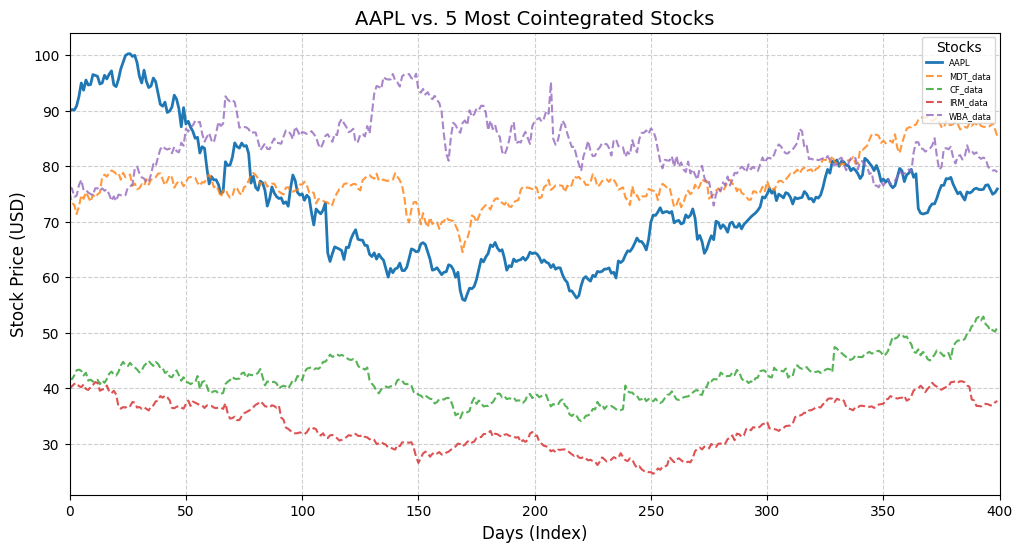

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import coint
from tqdm import tqdm
###CO INTEGRATION STOCKS
# Load AAPL data
stock = "AAPL_data"
aapl = stock_data_dict[stock]

def get_cointegration_pvalue(stock_df, aapl):
    """
    Computes the cointegration p-value between AAPL and another stock.
    """
    # Filter common dates
    aapl_filtered = aapl[aapl['Date'].isin(stock_df['Date'])]
    stock_filtered = stock_df[stock_df['Date'].isin(aapl['Date'])]

    # Extract closing prices
    aapl_close = aapl_filtered["Close"]
    stock_close = stock_filtered["Close"]

    # Ensure minimum data length for valid cointegration analysis
    if len(stock_close) < 200:
        return None  # Skip stocks with less than 200 days of data

    # Compute cointegration p-value
    _, p_value, _ = coint(aapl_close, stock_close, trend="ctt")
    return p_value

# Compute cointegration for stocks with sufficient data
cointegration_pvalues = {}

for stk in tqdm(stock_data_dict):
    if stk != 'AAPL_data':
        stock_data = stock_data_dict[stk]
        try:
            p_value = get_cointegration_pvalue(stock_data, aapl)
            if p_value is not None:
                cointegration_pvalues[stk] = p_value
        except Exception as e:
            print(f"Skipping {stk} due to error: {e}")
            continue

# Sort stocks by lowest p-value (strongest cointegration)
sorted_stocks = sorted(cointegration_pvalues.items(), key=lambda x: x[1])
top_5_stocks = sorted_stocks[:5]

# Print top 5 most similar stocks
print("\nTop 5 stocks most similar to AAPL based on cointegration:")
for s, p_value in top_5_stocks:
    print(f"{s}: p-value = {p_value:.4f}")

# --------------------------------------------------
# 📊 Plot: AAPL vs. Top 5 Stocks Based on Cointegration
# --------------------------------------------------
def plot_cointegration_top5(stock_data_dict, top_5_stocks, max_days=400):
    """
    Plots AAPL against the 5 most cointegrated stocks, limiting x-axis to max_days.
    The legend is placed at the top-right for better readability.
    """
    plt.figure(figsize=(12, 6))

    # Plot AAPL stock price
    aapl_prices = stock_data_dict['AAPL_data']['Close'].values[:max_days]
    plt.plot(aapl_prices, label="AAPL", linewidth=2, linestyle="-")

    # Plot each of the top 5 cointegrated stocks
    for s, _ in top_5_stocks:
        if s!="EQIX_data":
          stock_prices = stock_data_dict[s]['Close'].values[:max_days]
          plt.plot(stock_prices, label=s, linestyle="--", alpha=0.8)

    # Titles & Labels
    plt.title("AAPL vs. 5 Most Cointegrated Stocks", fontsize=14)
    plt.xlabel("Days (Index)", fontsize=12)
    plt.ylabel("Stock Price (USD)", fontsize=12)

    # Move legend to the upper-right corner
    plt.legend(title="Stocks", fontsize=6, loc="upper right", frameon=True)

    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xlim(0, max_days)

    # Show plot
    plt.show()

# Generate the plot
plot_cointegration_top5(stock_data_dict, top_5_stocks, max_days=400)

